0.03 0.6 0.3


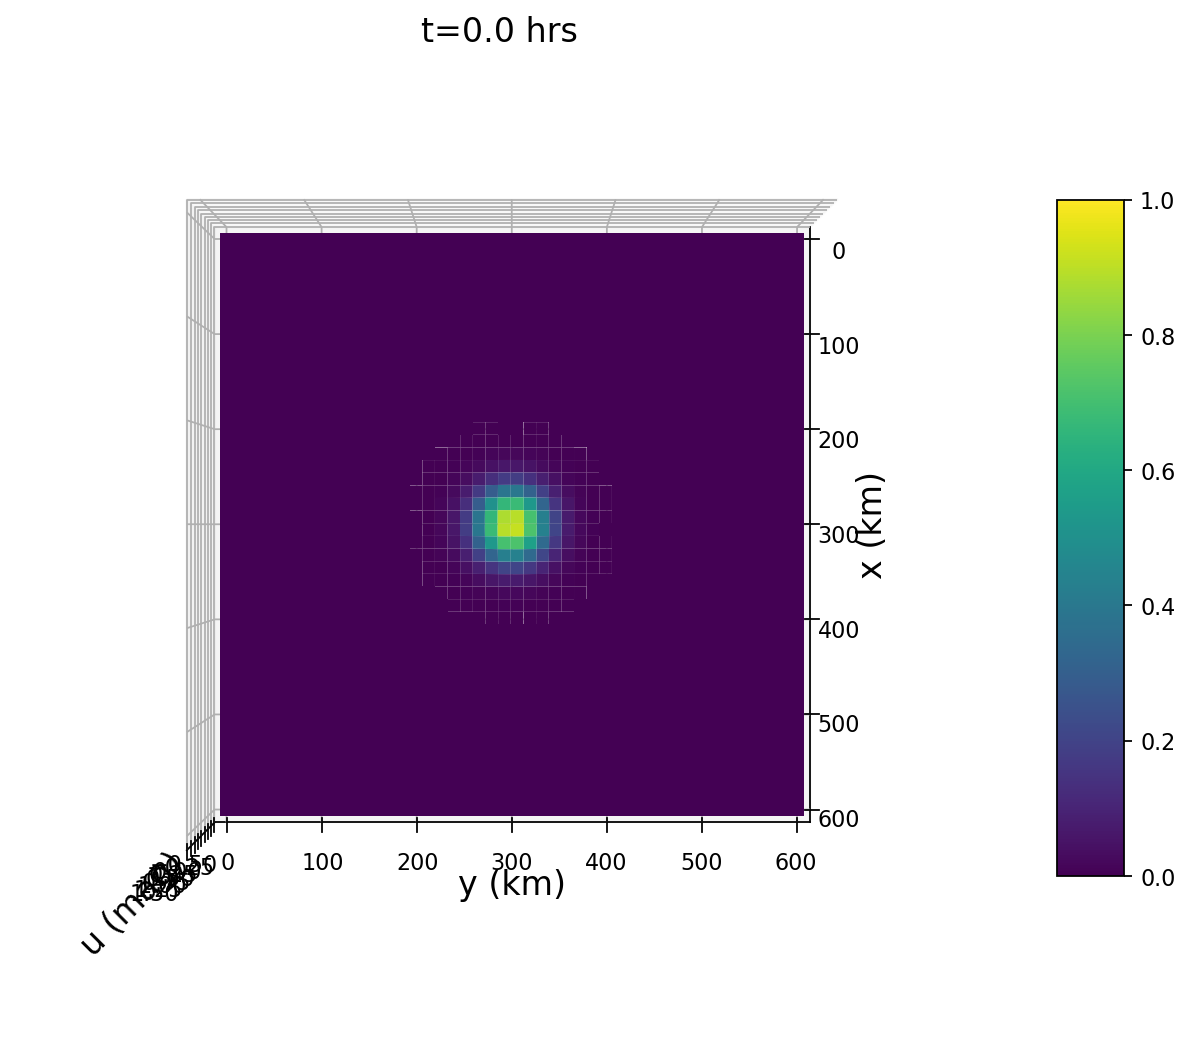

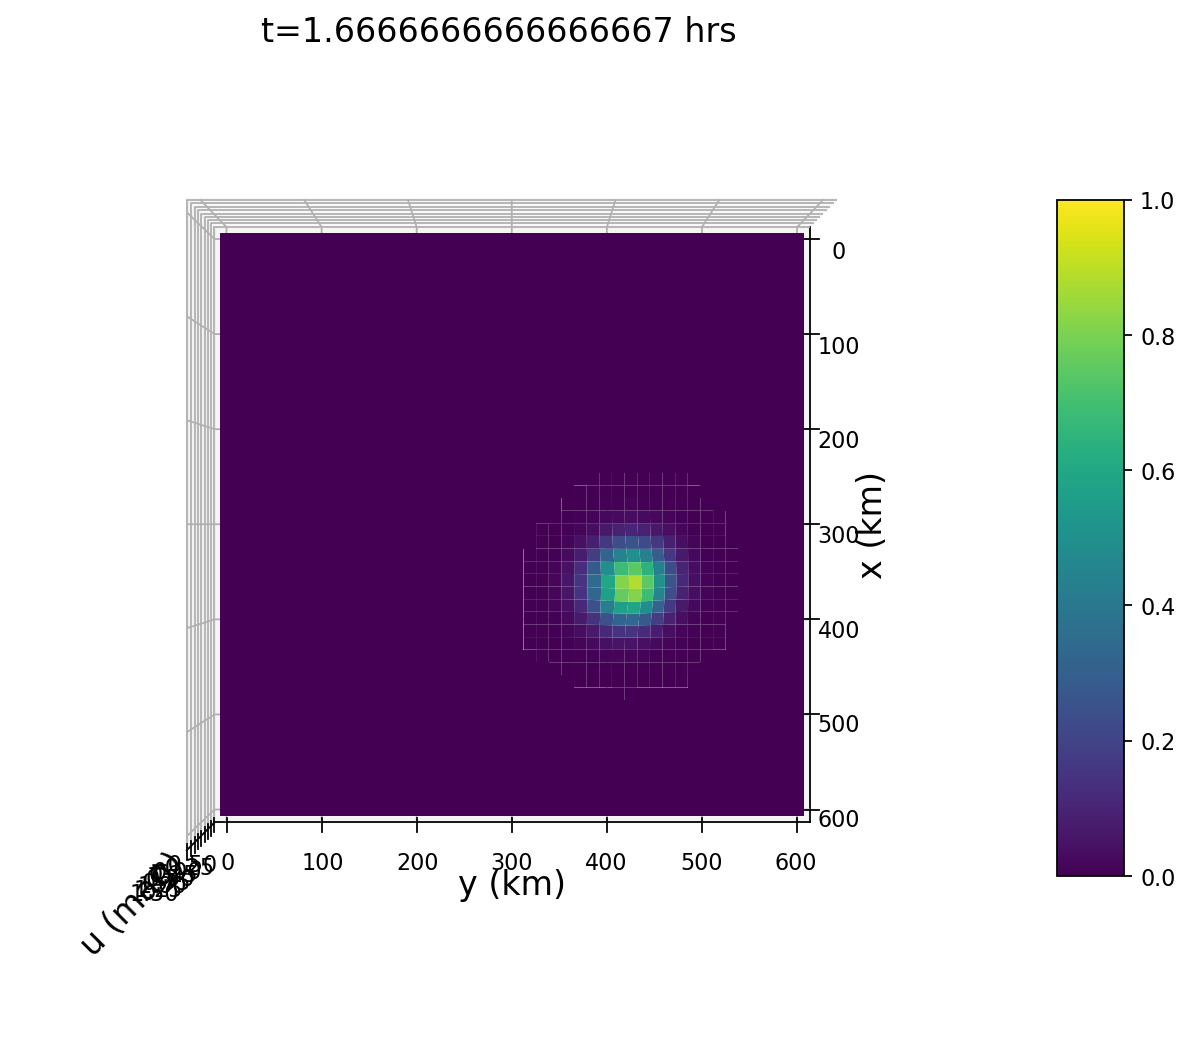

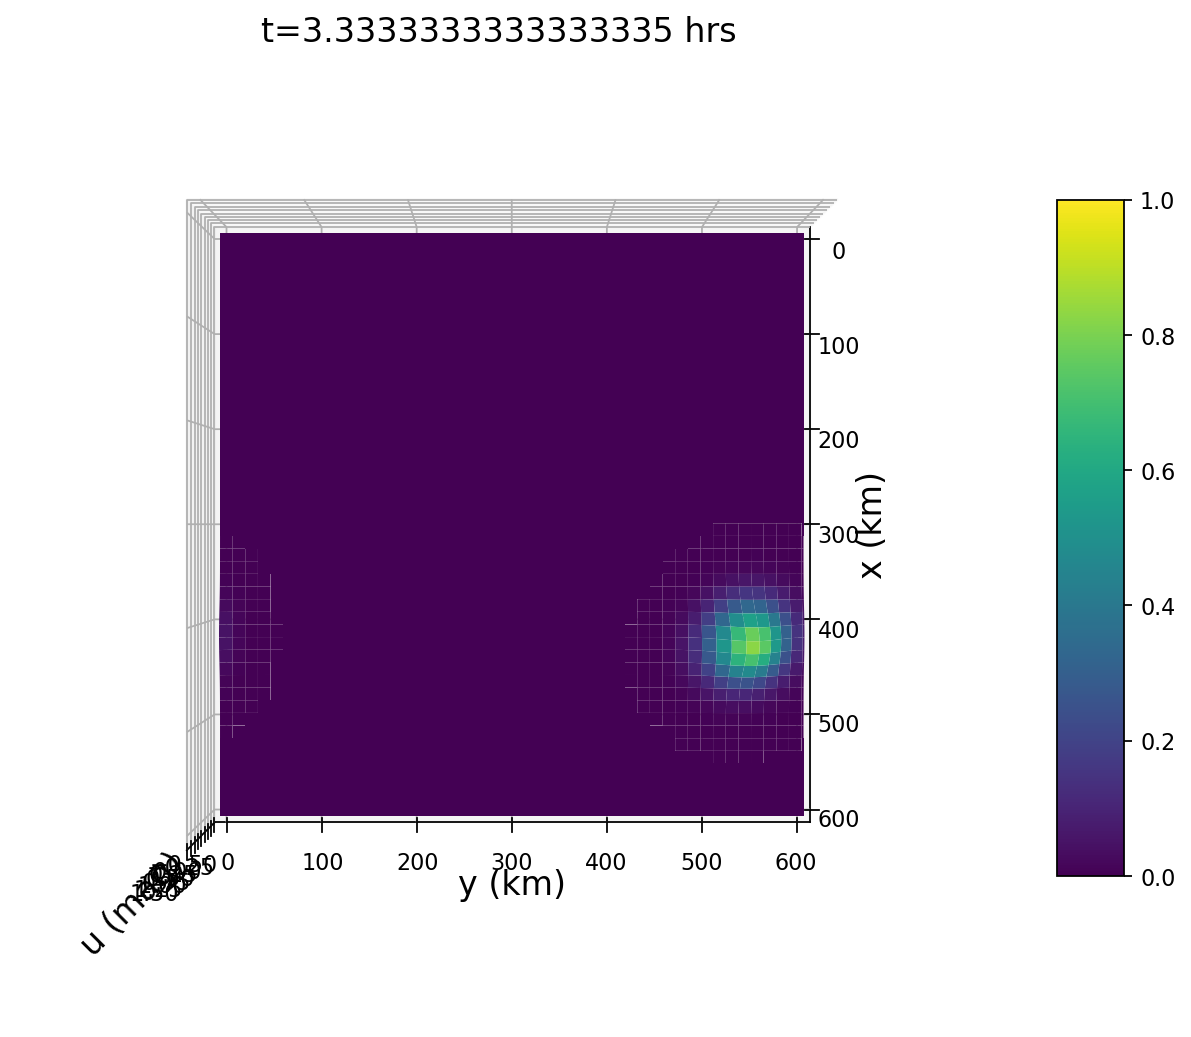

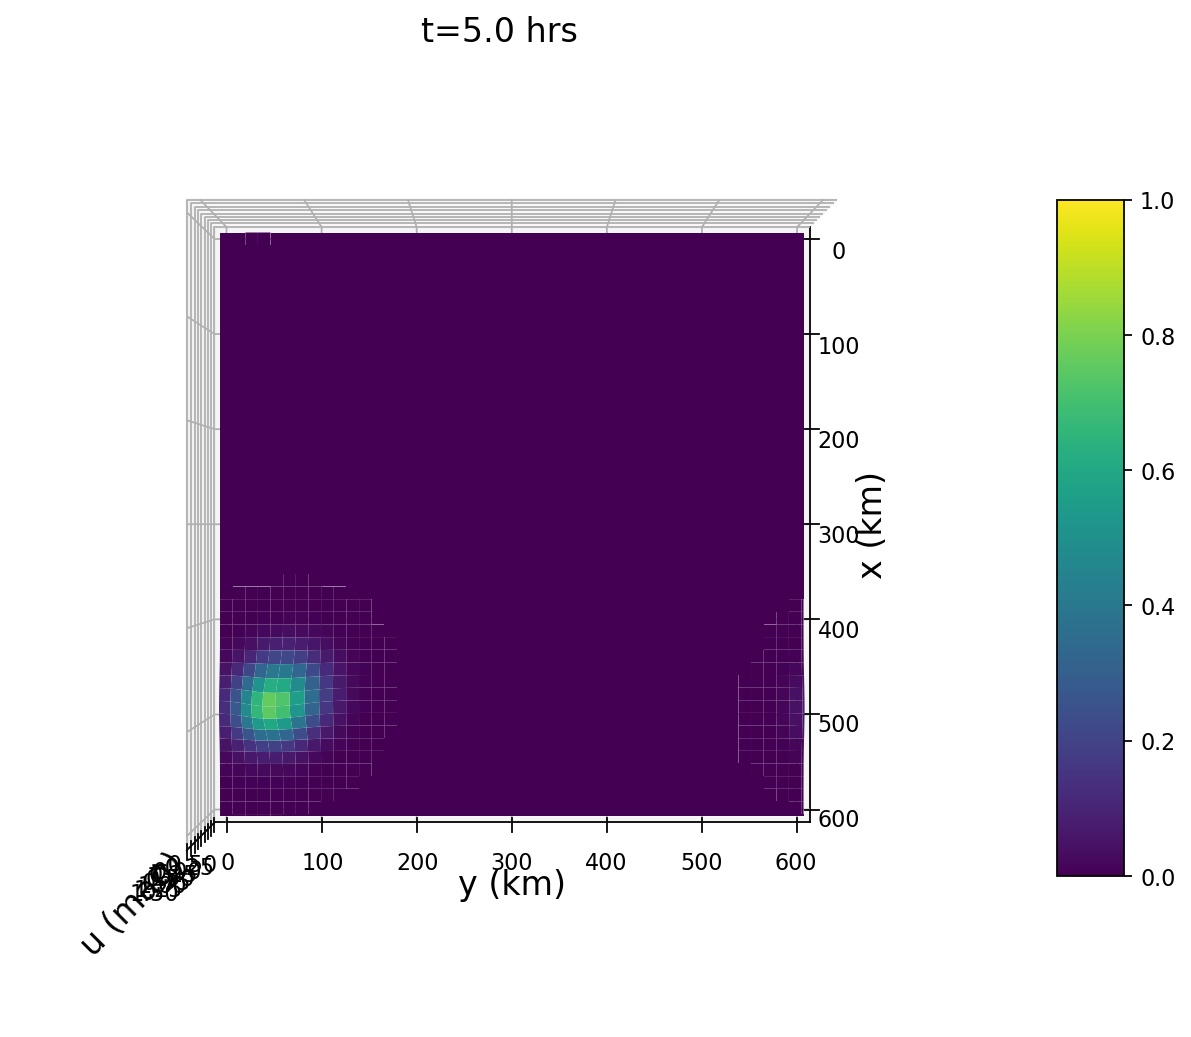

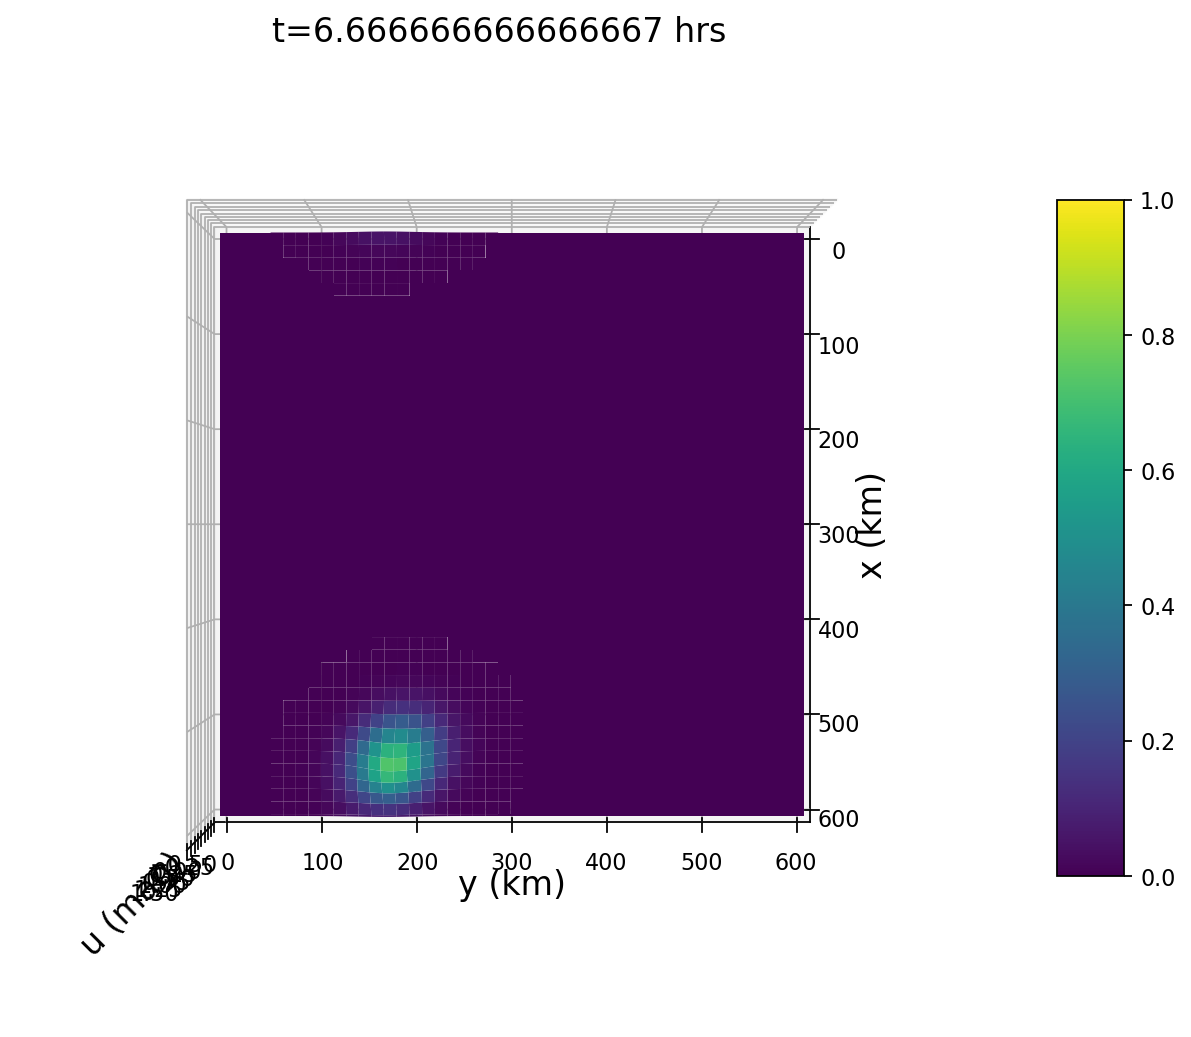

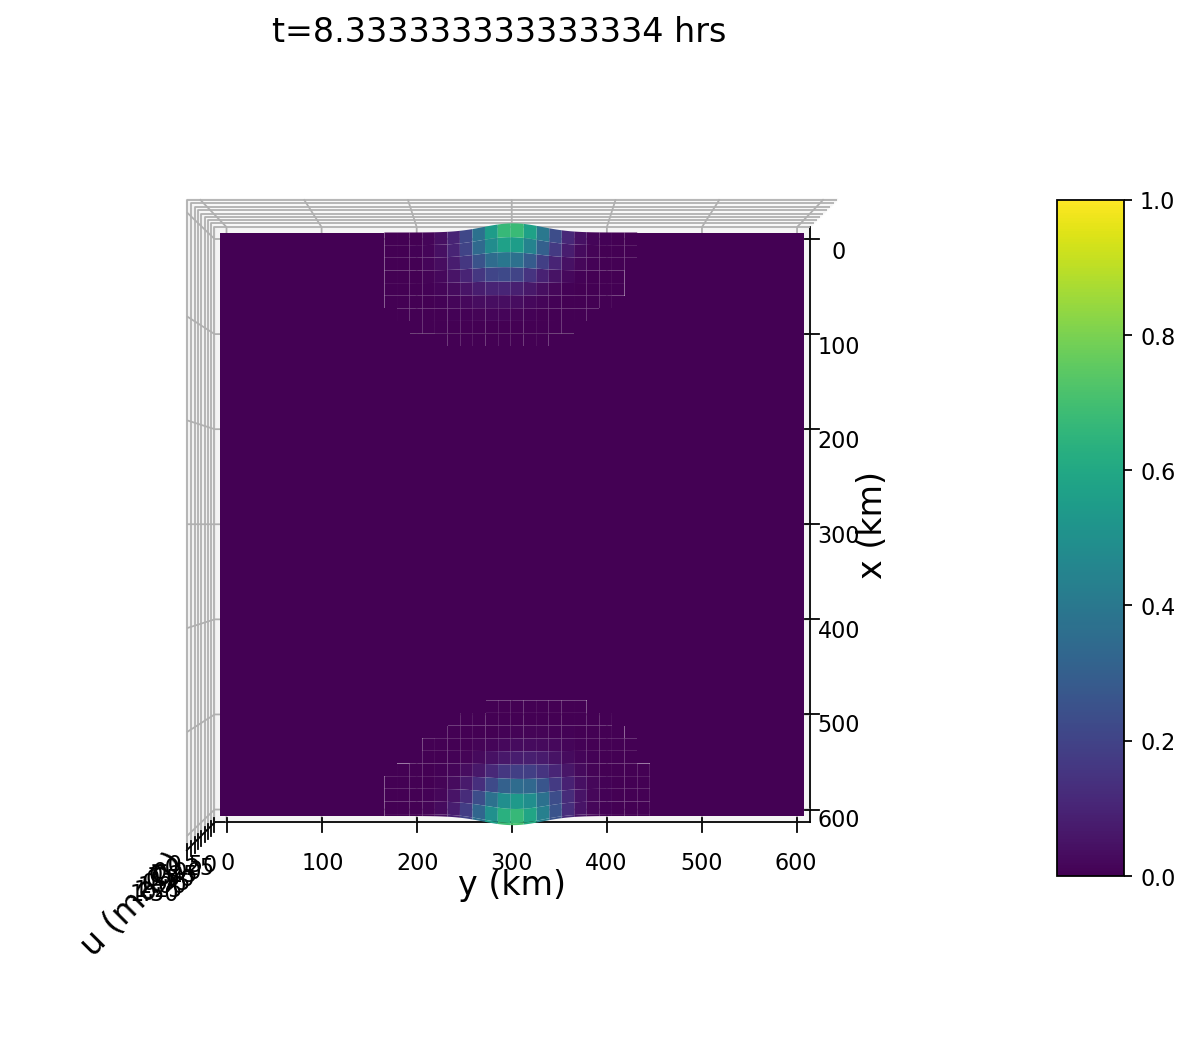

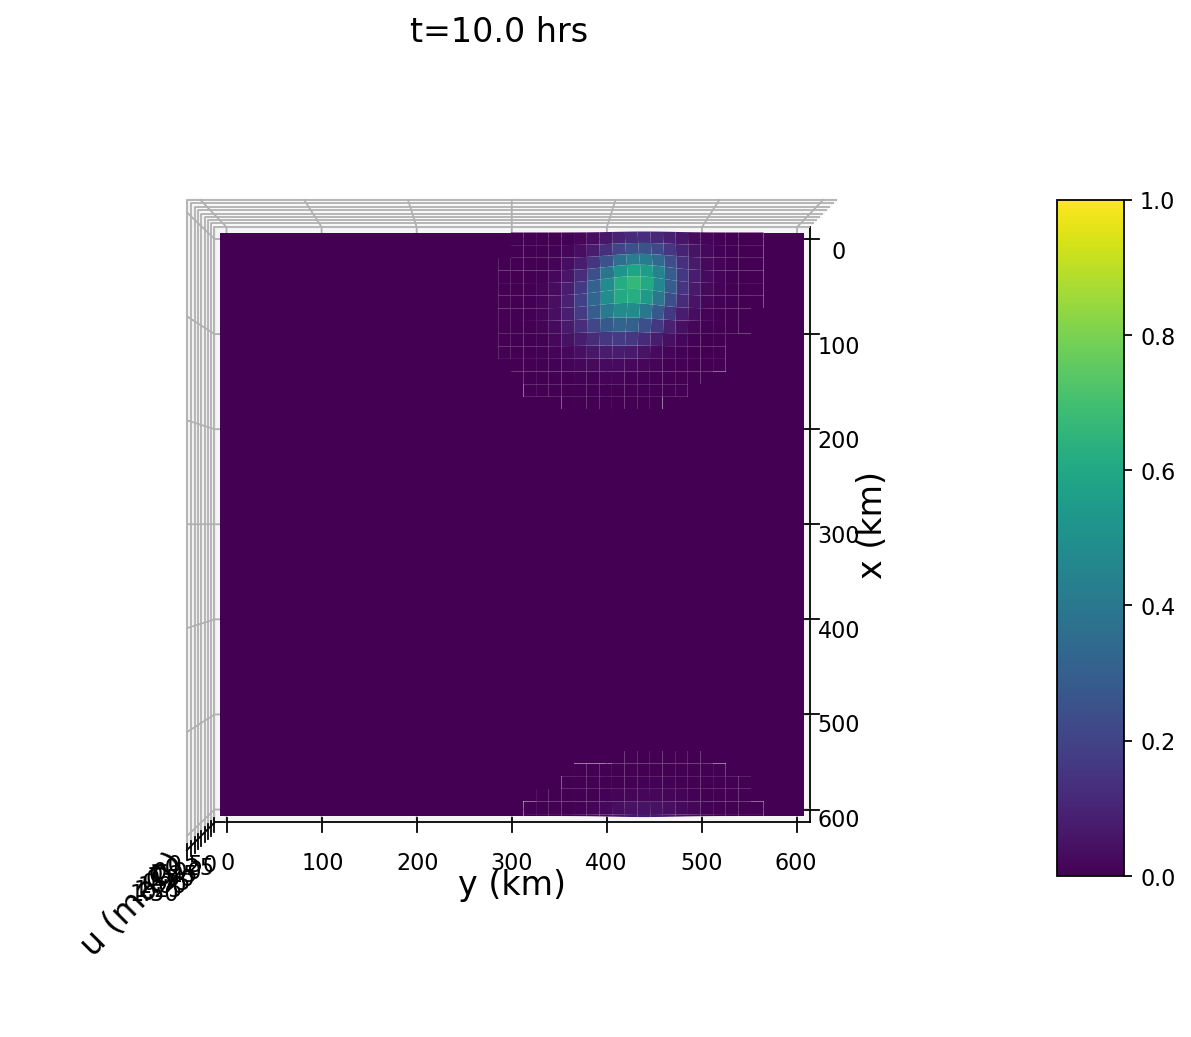

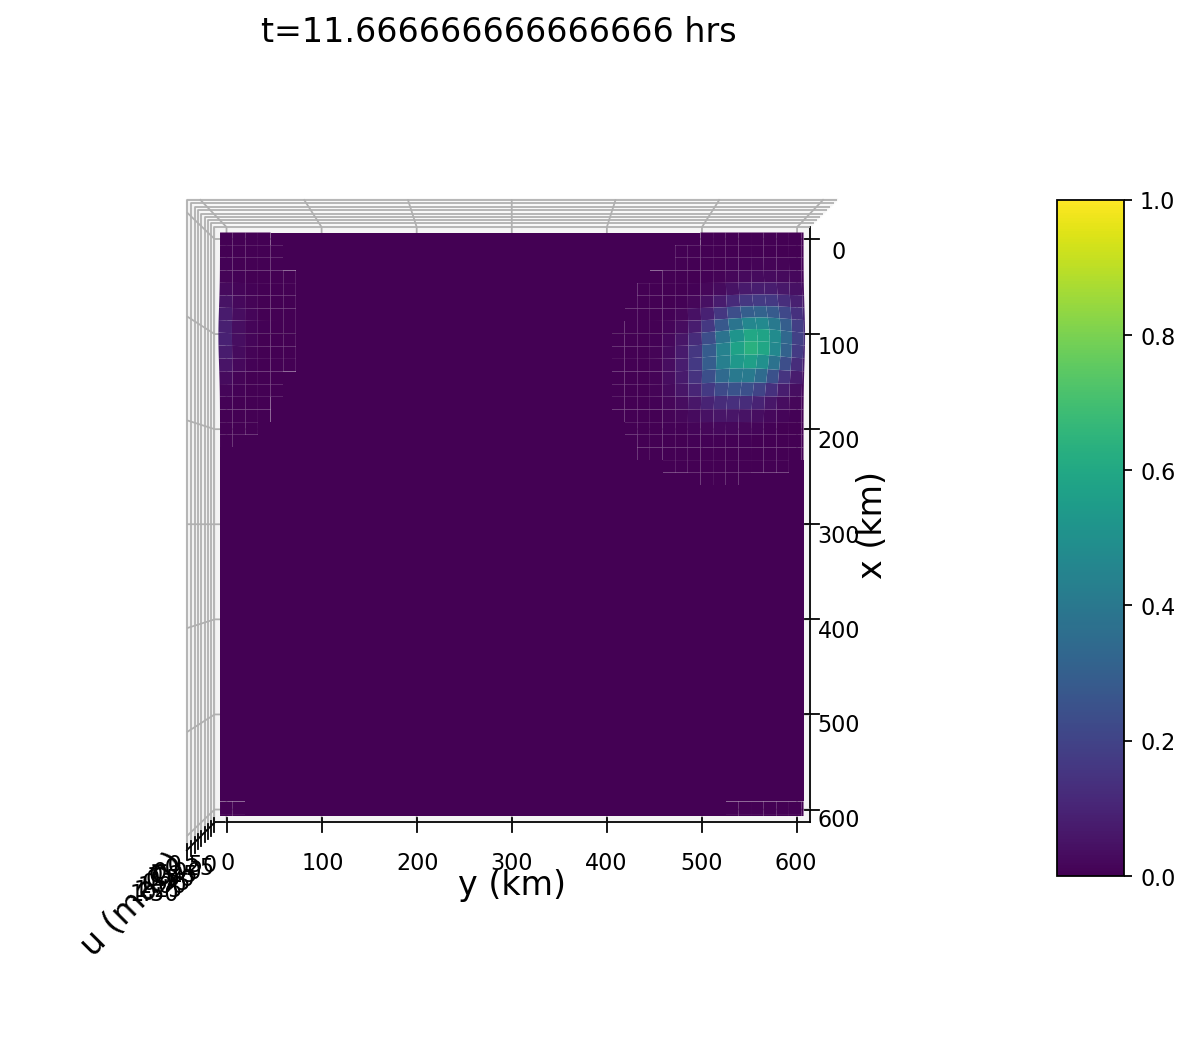

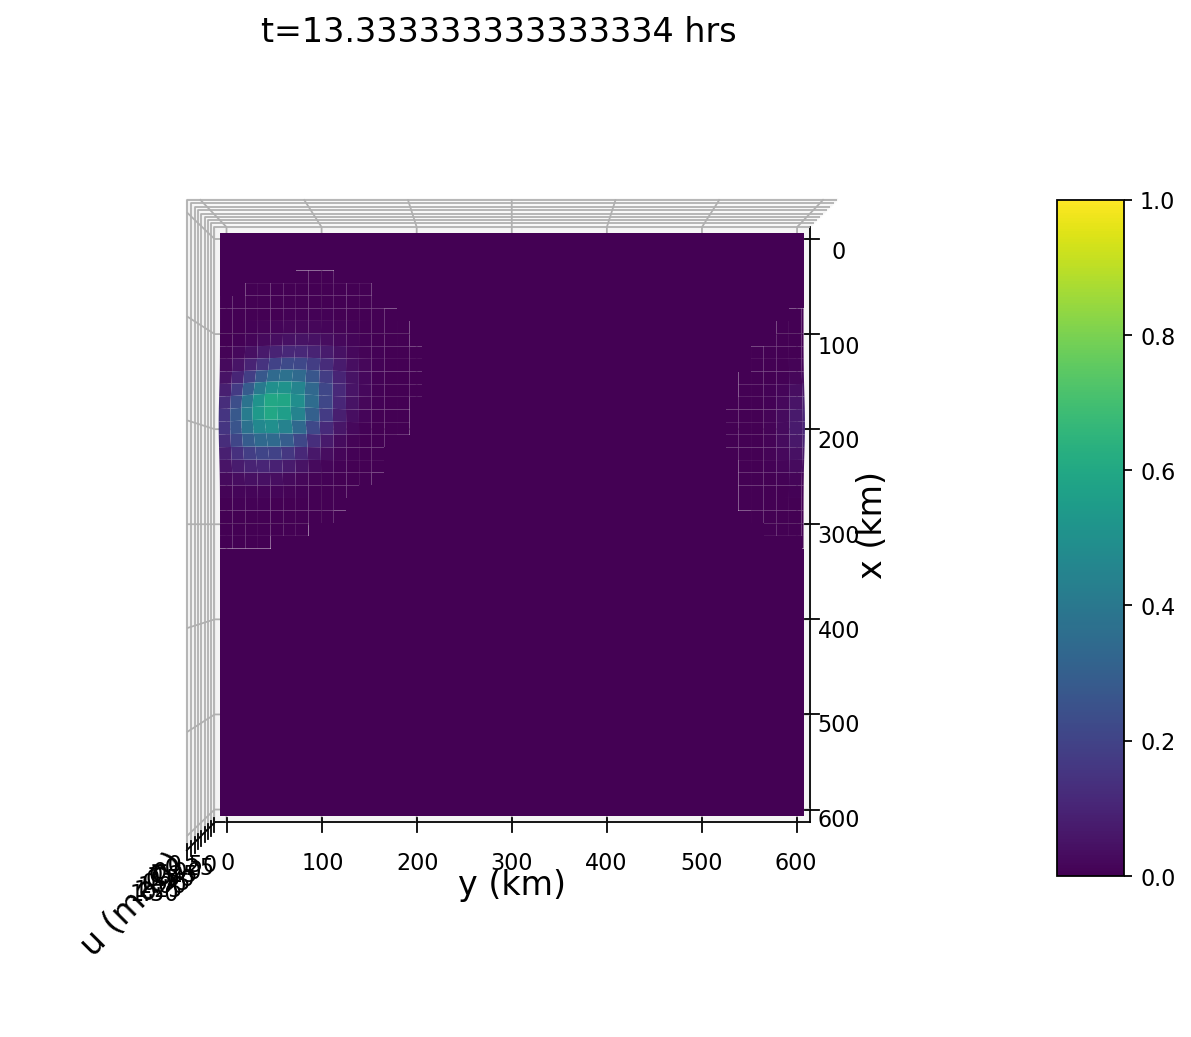

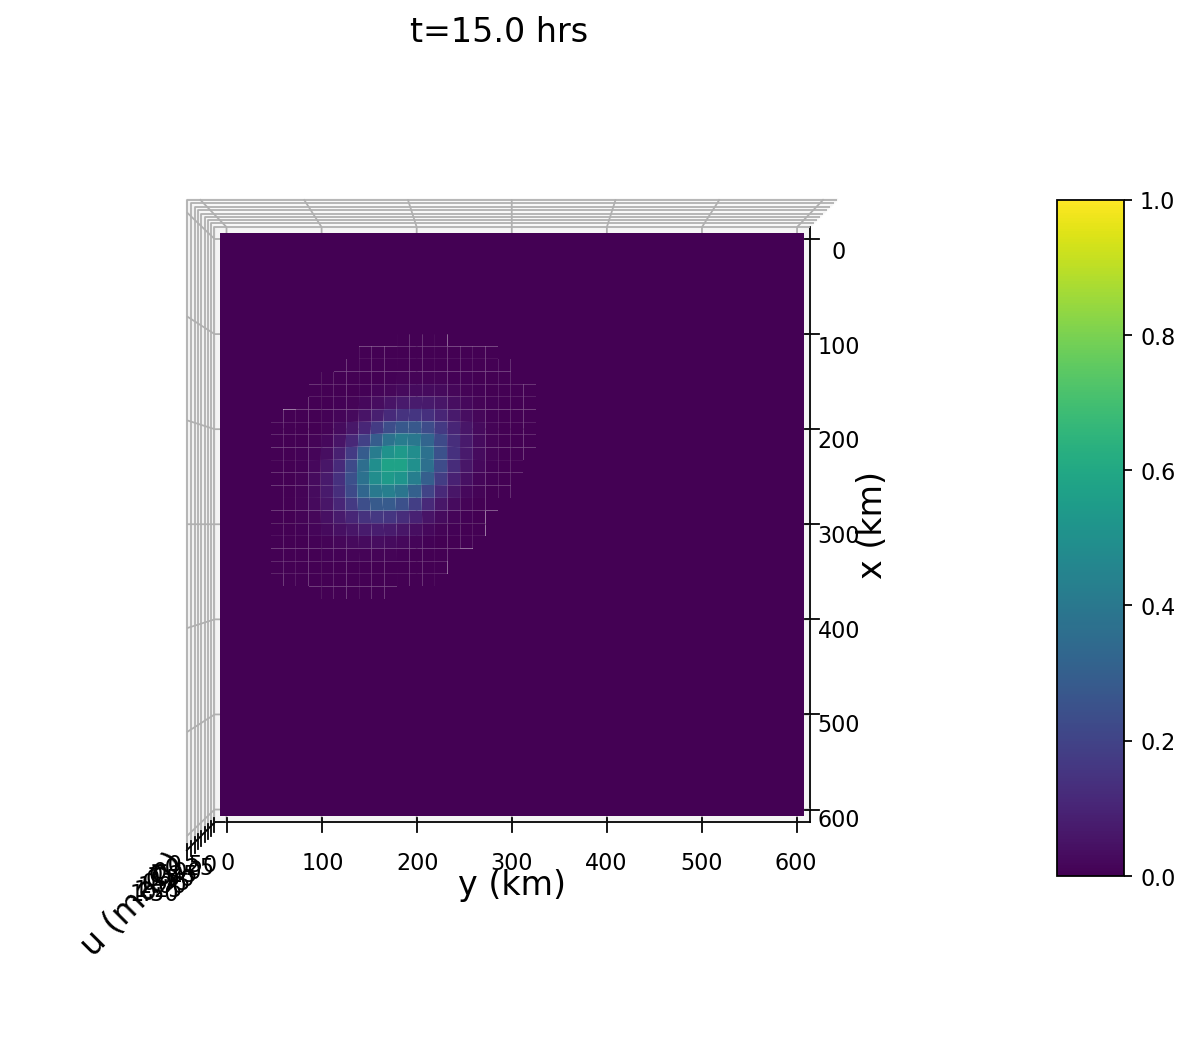

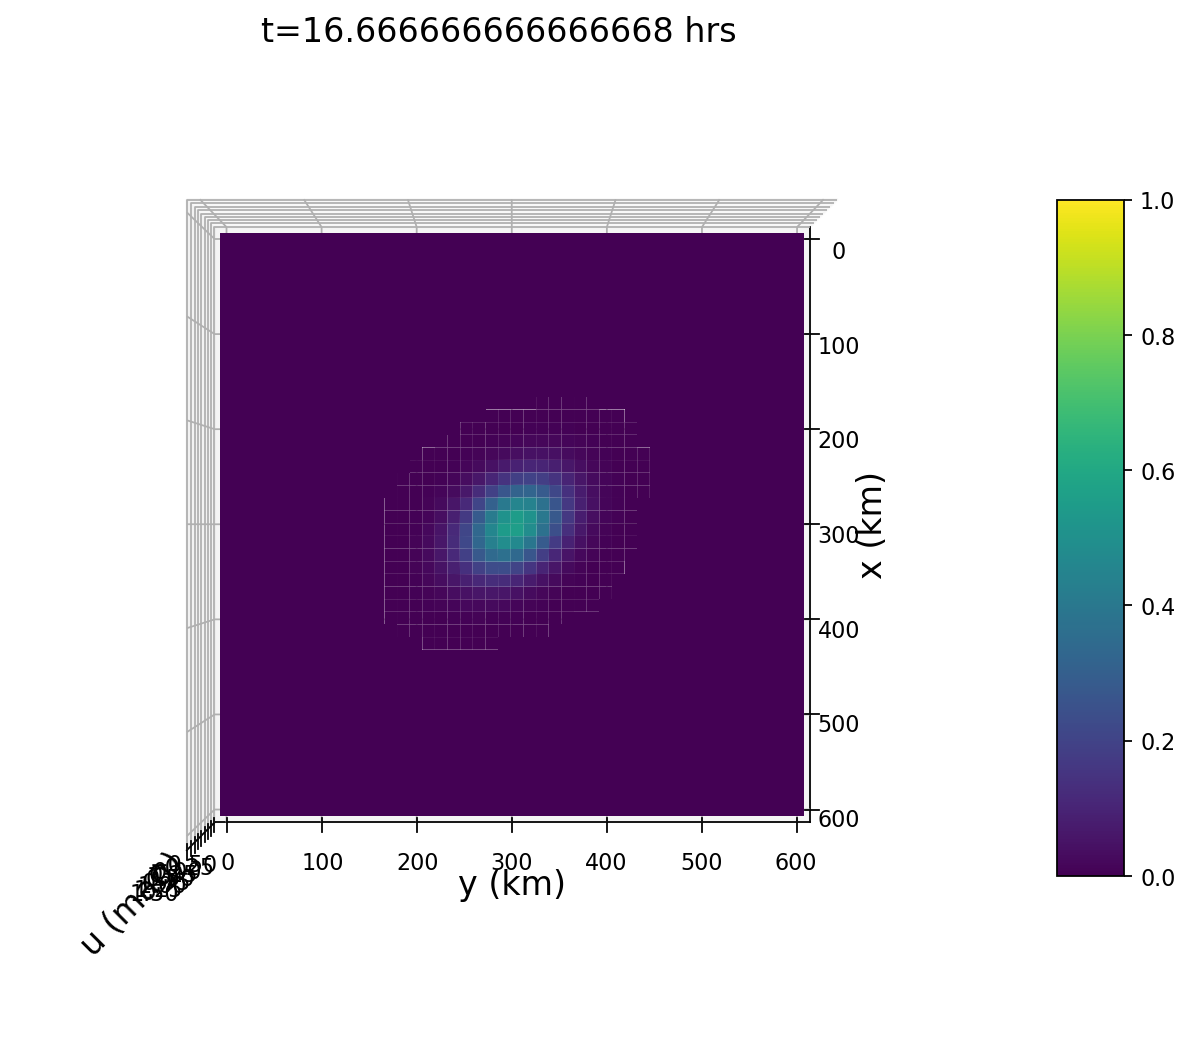

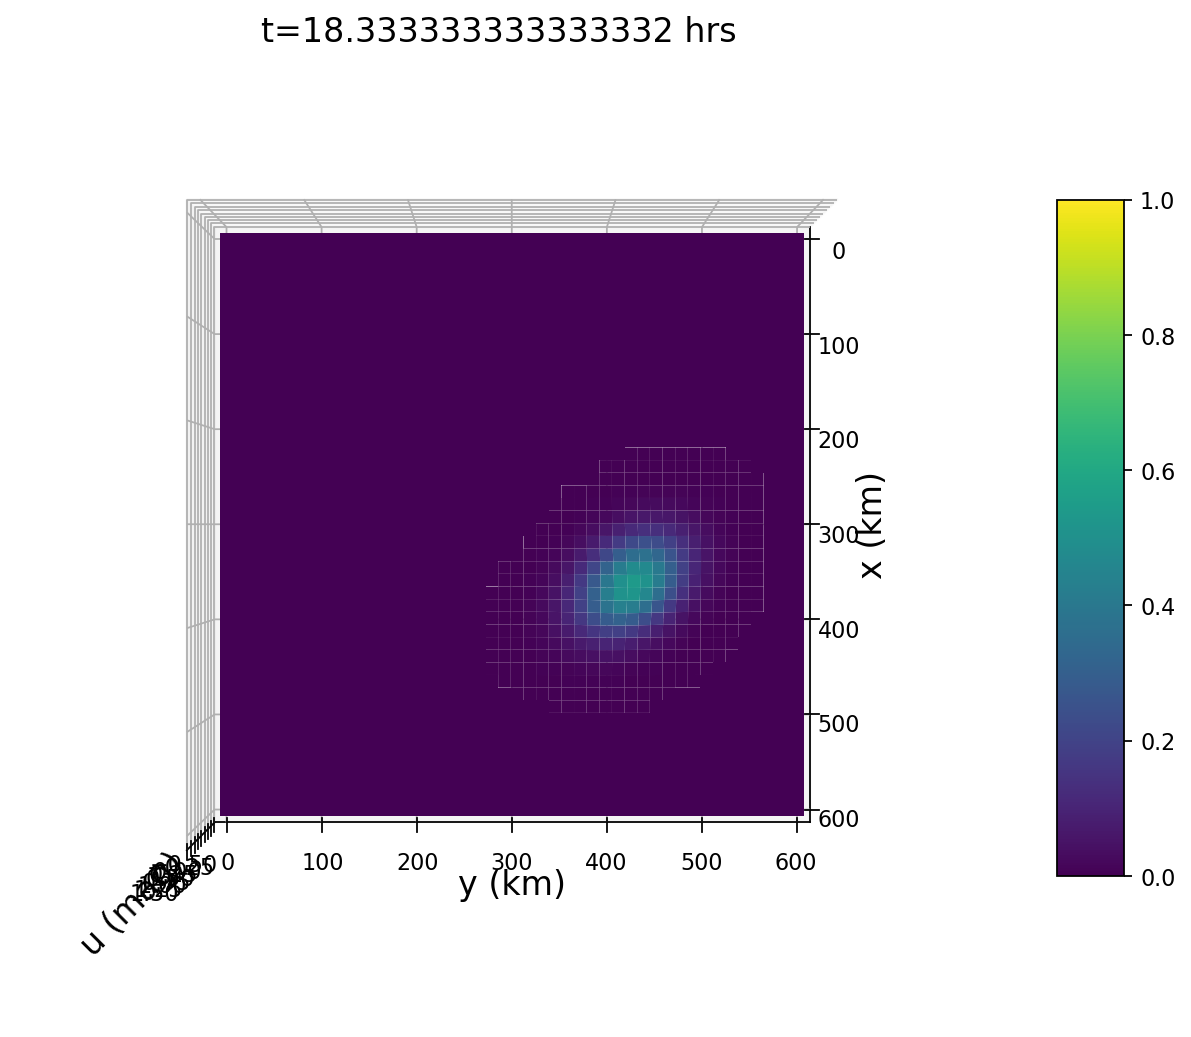

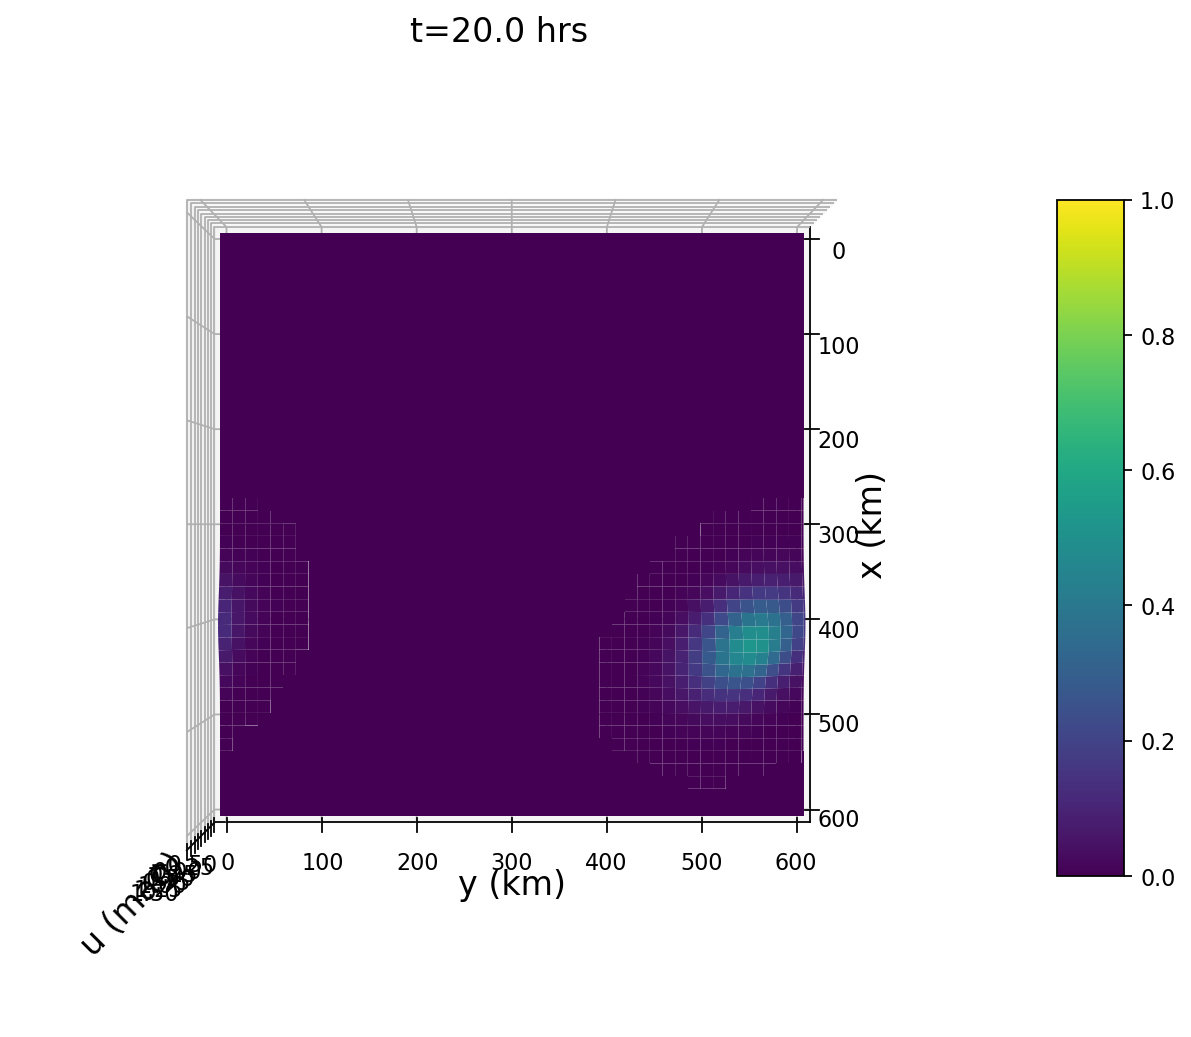

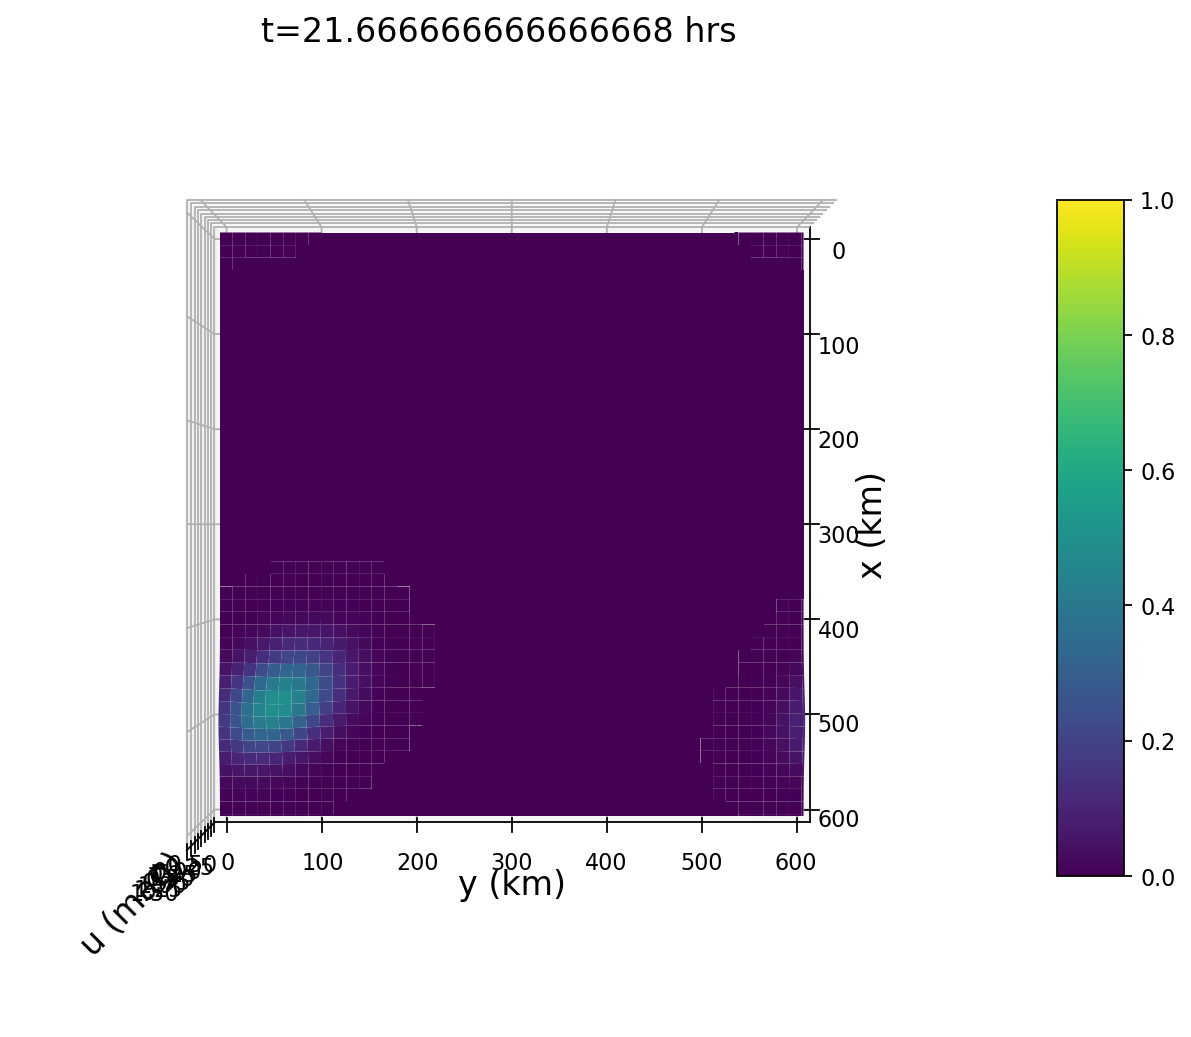


KeyboardInterrupt



In [1]:
from Advection_Diffusion import *

%matplotlib inline
%config InlineBackend.figure_format='retina'
Advection_Diffusion()

# rho, sigma              # rho, sigma <= 1 for stability